<a href="https://colab.research.google.com/github/Aswani-ReddyKV/Automatic_Ticket_Classification/blob/main/Automatic_Ticket_Classification_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [59]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning:

[W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
import pathlib
rootfolder = '/content/drive/MyDrive/Colab Notebooks/TicketClassification'

In [62]:
# Opening JSON file
f = open(rootfolder+'/complaints-2021-05-14_08_16.json')

# returns JSON object as
# a dictionary
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [63]:
# Inspect the dataframe to understand the given data.
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [64]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [65]:
#Assign new column names
df.rename(columns={'_index':'index',
  '_type':'type',
  '_id':'id',
  '_score':'score',
  '_source.tags':'tags',
  '_source.zip_code':'',
 '_source.complaint_id':'complaint_id',
 '_source.issue':'issue',
 '_source.date_received':'date_received',
 '_source.state':'state',
 '_source.consumer_disputed':'consumer_disputed',
 '_source.product':'product',
 '_source.company_response':'company_response',
 '_source.company':'company',
 '_source.submitted_via':'submitted_via',
 '_source.date_sent_to_company':'date_sent_to_company',
 '_source.company_public_response':'company_public_response',
 '_source.sub_product':'sub_product',
 '_source.timely':'timely',
 '_source.complaint_what_happened':'complaint_what_happened',
 '_source.sub_issue':'sub_issue',
 '_source.consumer_consent_provided':'consumer_consent_provided'},inplace=True)

In [66]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'].replace('', np.nan, inplace=True)

<ipython-input-66-d76549b330c8>:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [67]:
#Get the sum of rows where complaints column is nan
df['complaint_what_happened'].isnull().sum()

57241

In [68]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaint_what_happened'],inplace=True)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [69]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_data(text):
  text=text.lower()  #Make the text lowercase
  text=re.sub(r'^\[[\w\s]\]+$',' ',text) #Remove text in square brackets
  text=re.sub(r'[^\w\s]',' ',text) #Remove punctuation
  text=re.sub(r'^[a-zA-Z]\d+\w*$',' ',text) #Remove words containing numbers
  return text

In [70]:
#Write your function to Lemmatize the texts
def lemmatize_data(text):
    tokens = word_tokenize(text)
    wordnet_lemmatizer = WordNetLemmatizer()
    lemmatized = [wordnet_lemmatizer.lemmatize(token) for token in tokens]
    lemmatized_text = " ".join(lemmatized)
    return lemmatized_text

In [71]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean = pd.DataFrame()

In [72]:
#Apply clean_data and update to new dataframe
df_clean['complaint_what_happened'] = df['complaint_what_happened'].apply(lambda x: clean_data(x))

In [73]:
#Apply clean_data and update to new dataframe
df_clean['complaint_what_happened_lemmatized'] = df_clean['complaint_what_happened'].apply(lambda x: lemmatize_data(x))

In [74]:
#Write your function to extract the POS tags
from tqdm import tqdm

def pos_tag(text):
  pos_sentences = []
  for doc in tqdm(nlp.pipe(text)):
    sent = [token.text for token in doc if token.tag_ == 'NN']
    pos_sentences.append(' '.join(sent))
  return pos_sentences



df_clean["complaint_POS_removed"] =  pos_tag(df_clean['complaint_what_happened_lemmatized'])


21072it [08:12, 42.80it/s]


In [75]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,complaint_what_happened,complaint_what_happened_lemmatized,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...
2,i upgraded my xxxx xxxx card in xx xx 2018 and...,i upgraded my xxxx xxxx card in xx xx 2018 and...,xxxx card agent anniversary date agent informa...
10,chase card was reported on xx xx 2019 however...,chase card wa reported on xx xx 2019 however f...,card application identity consent service cred...
11,on xx xx 2018 while trying to book a xxxx xx...,on xx xx 2018 while trying to book a xxxx xxxx...,xxxx ticket offer ticket reward card informati...
14,my grand son give me check for 1600 00 i de...,my grand son give me check for 1600 00 i depos...,son check chase account fund chase bank accoun...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




Text(0.5, 0, 'Complaint character length')

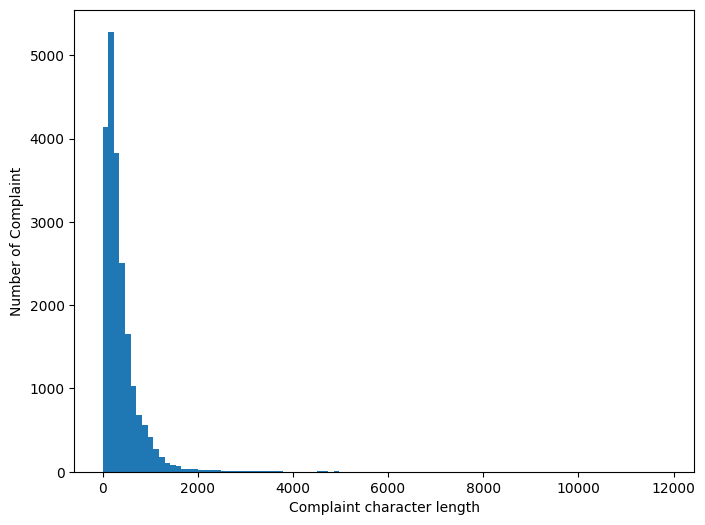

In [76]:
# Write your code here to visualise the data according to the 'Complaint' character length
plt.figure(figsize=(8,6))
doc_lens = [len(d) for d in df_clean.complaint_POS_removed]
plt.hist(doc_lens, bins = 100)
plt.ylabel('Number of Complaint')
plt.xlabel('Complaint character length')

#### Find the top 40 words by frequency among all the articles after processing the text.

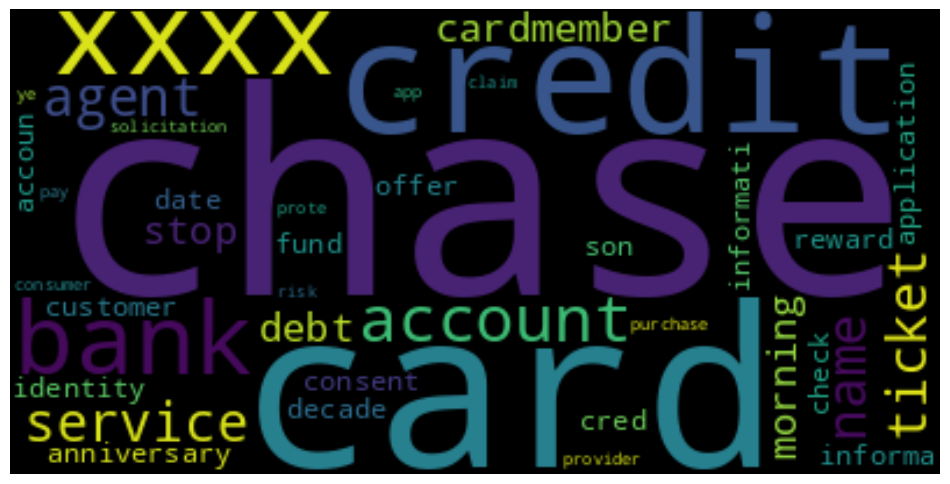

In [77]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text

from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(max_words=40, random_state=1, stopwords=set(STOPWORDS))
wordcloud.generate(str(df_clean['complaint_POS_removed']))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [78]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [79]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
def get_top_n_bigram(text, ngram=1, top=None):
    vec = CountVectorizer(ngram_range=(ngram, ngram), stop_words='english').fit(text)
    bag_of_words = vec.transform(text)

    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top]

In [80]:
top_30_unigrams = get_top_n_bigram(df_clean.Complaint_clean,ngram=1, top=30)
top_30_bigrams = get_top_n_bigram(df_clean.Complaint_clean,ngram=2, top=30)
top_30_trigrams = get_top_n_bigram(df_clean.Complaint_clean,ngram=3, top=30)

In [81]:
#Print the top 10 words in the unigram frequency
print('Top 10 unigrams:\n')
top_30_unigrams[:10]

Top 10 unigrams:



[('chase', 52321),
 ('account', 46551),
 ('xxxx', 44983),
 ('credit', 32708),
 ('card', 30266),
 ('payment', 21350),
 ('bank', 20983),
 ('time', 16305),
 ('day', 13274),
 ('money', 12001)]

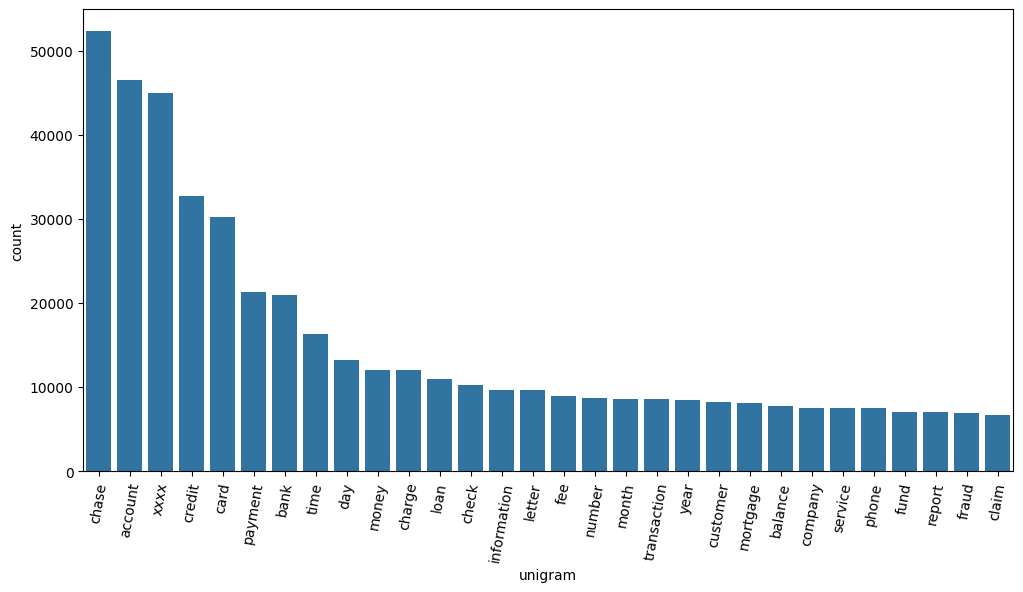

In [82]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
df1 = pd.DataFrame(top_30_unigrams, columns = ['unigram' , 'count'])
plt.figure(figsize=(12,6))
fig = sns.barplot(x=df1['unigram'], y=df1['count'])
plt.xticks(rotation = 80)
plt.show()

In [83]:
#Print the top 10 words in the bigram frequency
print('Top 10 bigrams:\n')
top_30_bigrams[:10]

Top 10 bigrams:



[('credit card', 12899),
 ('xxxx xxxx', 5148),
 ('credit report', 3854),
 ('account chase', 3207),
 ('customer service', 3066),
 ('chase credit', 2941),
 ('chase account', 2936),
 ('account account', 2704),
 ('bank account', 2530),
 ('chase bank', 2214)]

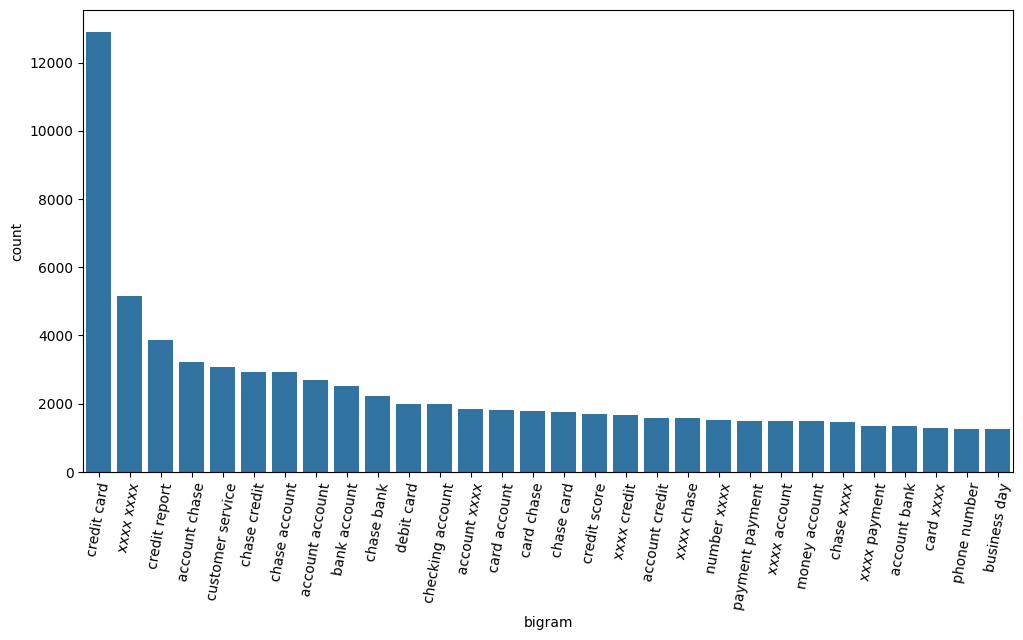

In [84]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
df1 = pd.DataFrame(top_30_bigrams, columns = ['bigram' , 'count'])
plt.figure(figsize=(12,6))
fig = sns.barplot(x=df1['bigram'], y=df1['count'])
plt.xticks(rotation = 80)
plt.show()

In [85]:
#Print the top 10 words in the trigram frequency
print('Top 10 trigrams:\n')
top_30_trigrams[:10]

Top 10 trigrams:



[('chase credit card', 1957),
 ('xxxx xxxx xxxx', 1517),
 ('credit card account', 1132),
 ('credit card company', 1000),
 ('xxxx credit card', 842),
 ('credit card chase', 793),
 ('credit card credit', 561),
 ('inquiry credit report', 519),
 ('credit card xxxx', 509),
 ('account credit card', 446)]

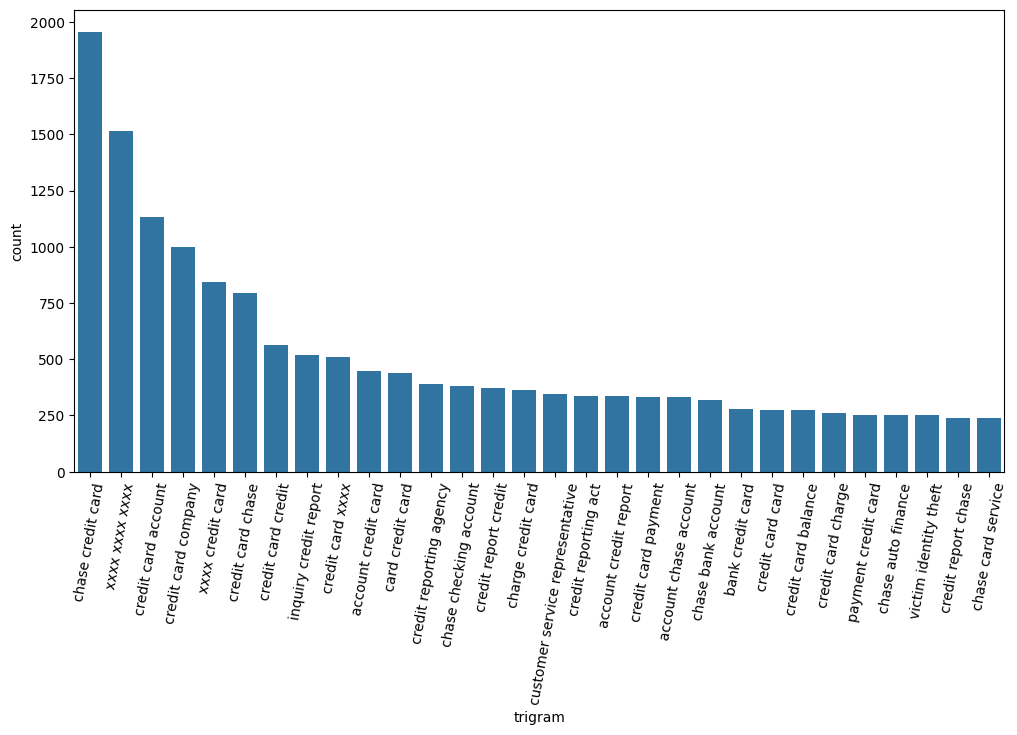

In [86]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
df3 = pd.DataFrame(top_30_trigrams, columns = ['trigram' , 'count'])
plt.figure(figsize=(12,6))
fig = sns.barplot(x=df3['trigram'], y=df3['count'])
plt.xticks(rotation = 80)
plt.show()

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [87]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [88]:
#All masked texts has been removed
df_clean.head()

,complaint_what_happened,complaint_what_happened_lemmatized,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,morning name stop bank cardmember service debt...
2,i upgraded my xxxx xxxx card in xx xx 2018 and...,i upgraded my xxxx xxxx card in xx xx 2018 and...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information...
10,chase card was reported on xx xx 2019 however...,chase card wa reported on xx xx 2019 however f...,card application identity consent service cred...,card application identity consent service cred...
11,on xx xx 2018 while trying to book a xxxx xx...,on xx xx 2018 while trying to book a xxxx xxxx...,xxxx ticket offer ticket reward card informati...,ticket offer ticket reward card information o...
14,my grand son give me check for 1600 00 i de...,my grand son give me check for 1600 00 i depos...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [89]:
#Write your code here to initialise the TfidfVectorizer
tfidf = TfidfVectorizer(max_df=0.95,min_df=2,stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [90]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['Complaint_clean'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [91]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [92]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [93]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())

5735

In [94]:
#Print the Top15 words for each of the topics
words = np.array(tfidf.get_feature_names_out())
topic_words_df = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)

for i in range(num_topics):
    ix = nmf_model.components_[i].argsort()[::-1][:15]
    topic_words_df.iloc[i] = words[ix]

topic_words_df

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,bank,money,fund,chase,deposit,branch,day,fee,checking,business,number,transaction,customer
Topic 2,card,credit,chase,balance,account,fee,limit,score,year,month,purchase,point,offer,service,reason
Topic 3,payment,loan,mortgage,chase,month,home,modification,time,year,rate,balance,property,fee,statement,day
Topic 4,inquiry,report,credit,company,information,bureau,reporting,debt,identity,score,theft,account,letter,application,creditor
Topic 5,charge,chase,transaction,dispute,claim,fraud,merchant,letter,email,service,information,time,phone,company,day


In [95]:
def top_words(topic, n_top_words):
    return topic.argsort()[:-n_top_words - 1:-1]

# Funtion to remove duplicate words
def unique_words(text):
    ulist = []
    [ulist.append(x) for x in text if x not in ulist]
    return ulist

# Cleaning up the top words to create topic summaries
topic_words_df['topics'] = topic_words_df.apply(lambda x: [' '.join(x)], axis=1) # Joining each word into a list
topic_words_df['topics'] = topic_words_df['topics'].apply(lambda x: unique_words(x))  # Removing duplicate words
topic_words_df['topics'] = topic_words_df['topics'].str[0]  # Removing the list brackets

topic_words_df

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,topics
Topic 1,account,check,bank,money,fund,chase,deposit,branch,day,fee,checking,business,number,transaction,customer,account check bank money fund chase deposit br...
Topic 2,card,credit,chase,balance,account,fee,limit,score,year,month,purchase,point,offer,service,reason,card credit chase balance account fee limit sc...
Topic 3,payment,loan,mortgage,chase,month,home,modification,time,year,rate,balance,property,fee,statement,day,payment loan mortgage chase month home modific...
Topic 4,inquiry,report,credit,company,information,bureau,reporting,debt,identity,score,theft,account,letter,application,creditor,inquiry report credit company information bure...
Topic 5,charge,chase,transaction,dispute,claim,fraud,merchant,letter,email,service,information,time,phone,company,day,charge chase transaction dispute claim fraud m...


In [96]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_values = nmf_model.transform(dtm)
topic_values.argmax(axis=1)

array([0, 1, 1, ..., 4, 1, 2])

In [97]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = topic_values.argmax(axis=1)

In [98]:
df_clean.head(10)

,complaint_what_happened,complaint_what_happened_lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,morning name stop bank cardmember service debt...,0
2,i upgraded my xxxx xxxx card in xx xx 2018 and...,i upgraded my xxxx xxxx card in xx xx 2018 and...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information...,1
10,chase card was reported on xx xx 2019 however...,chase card wa reported on xx xx 2019 however f...,card application identity consent service cred...,card application identity consent service cred...,1
11,on xx xx 2018 while trying to book a xxxx xx...,on xx xx 2018 while trying to book a xxxx xxxx...,xxxx ticket offer ticket reward card informati...,ticket offer ticket reward card information o...,3
14,my grand son give me check for 1600 00 i de...,my grand son give me check for 1600 00 i depos...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...,0
15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,3
17,with out notice j p morgan chase restricted m...,with out notice j p morgan chase restricted my...,notice account debit card branch customer serv...,notice account debit card branch customer serv...,0
20,during the summer months i experience a decli...,during the summer month i experience a decline...,summer month decline income employment month p...,summer month decline income employment month p...,2
21,on xxxx xx xx 2019 i made a 300 00 payment...,on xxxx xx xx 2019 i made a 300 00 payment to ...,payment retailer chase pay xxxx chase website ...,payment retailer chase pay chase website scam...,4
23,i have a chase credit card which is incorrectl...,i have a chase credit card which is incorrectl...,credit card credit report company issue,credit card credit report company issue,3


In [99]:
#Print the first 5 Complaint for each of the Topics
df_clean.groupby('Topic').head(5).sort_values(by='Topic')

,complaint_what_happened,complaint_what_happened_lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,morning name stop bank cardmember service debt...,0
14,my grand son give me check for 1600 00 i de...,my grand son give me check for 1600 00 i depos...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...,0
17,with out notice j p morgan chase restricted m...,with out notice j p morgan chase restricted my...,notice account debit card branch customer serv...,notice account debit card branch customer serv...,0
24,mishandling of this account by chase auto and ...,mishandling of this account by chase auto and ...,account chase auto xxxx,account chase auto,0
27,i opened an account with chase bank on xxxx an...,i opened an account with chase bank on xxxx an...,account bank code term everything account xxxx...,account bank code term everything account dep...,0
32,my chase amazon card was declined for a cateri...,my chase amazon card wa declined for a caterin...,chase catering order brother funeral amount ch...,chase catering order brother funeral amount ch...,1
10,chase card was reported on xx xx 2019 however...,chase card wa reported on xx xx 2019 however f...,card application identity consent service cred...,card application identity consent service cred...,1
2,i upgraded my xxxx xxxx card in xx xx 2018 and...,i upgraded my xxxx xxxx card in xx xx 2018 and...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information...,1
40,xxxx xxxx a sofa love seat table and chairs ...,xxxx xxxx a sofa love seat table and chair and...,sofa love seat table chair debit card bank vis...,sofa love seat table chair debit card bank vis...,1
50,i am a senior citizen that has been scammed by...,i am a senior citizen that ha been scammed by ...,citizen company time share company nothing ref...,citizen company time share company nothing ref...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [100]:
#Create the dictionary of Topic names and Topics
Topic_names = {0:'Account Services', 1:'Credit card or prepaid card', 2:'Mortgage/Loan',  3:'Theft/Dispute Reporting', 4:'Others'}

# Replace Topics with Topic Names
df_clean['Topic_category'] = df_clean['Topic'].map(Topic_names)

In [101]:
df_clean.head()

,complaint_what_happened,complaint_what_happened_lemmatized,complaint_POS_removed,Complaint_clean,Topic,Topic_category
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,morning name stop bank cardmember service debt...,0,Account Services
2,i upgraded my xxxx xxxx card in xx xx 2018 and...,i upgraded my xxxx xxxx card in xx xx 2018 and...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information...,1,Credit card or prepaid card
10,chase card was reported on xx xx 2019 however...,chase card wa reported on xx xx 2019 however f...,card application identity consent service cred...,card application identity consent service cred...,1,Credit card or prepaid card
11,on xx xx 2018 while trying to book a xxxx xx...,on xx xx 2018 while trying to book a xxxx xxxx...,xxxx ticket offer ticket reward card informati...,ticket offer ticket reward card information o...,3,Theft/Dispute Reporting
14,my grand son give me check for 1600 00 i de...,my grand son give me check for 1600 00 i depos...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...,0,Account Services


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [102]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['complaint_what_happened','Topic']]

In [103]:
training_data.head()

,complaint_what_happened,Topic
1,good morning my name is xxxx xxxx and i apprec...,0
2,i upgraded my xxxx xxxx card in xx xx 2018 and...,1
10,chase card was reported on xx xx 2019 however...,1
11,on xx xx 2018 while trying to book a xxxx xx...,3
14,my grand son give me check for 1600 00 i de...,0


In [104]:
training_data.count()


,0
complaint_what_happened,21072
Topic,21072


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [105]:
from sklearn.feature_extraction.text import TfidfTransformer

# Write your code to get the Vector count
count_vect = CountVectorizer()
X_train_counts=count_vect.fit_transform(training_data['complaint_what_happened'])
# Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [106]:
# Write your code here to build any 3 models and evaluate them using the required metrics

# importing libraries required for model building and evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

from sklearn.model_selection import StratifiedKFold,GridSearchCV,train_test_split

from sklearn.metrics import roc_auc_score,accuracy_score,precision_score,recall_score,f1_score,classification_report
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay



In [107]:
# Prepare the training and test data
train_X, test_X, train_y, test_y = train_test_split(X_train_tfidf, training_data['Topic'], test_size=0.2, random_state=40)

1. Logistic Regression

In [108]:
def eval_model(y_test,y_pred,y_pred_proba,type='Training'):
    print(type,'results')
    print('Accuracy: ', round(accuracy_score(y_test,y_pred), 2)) # Use the built-in round function
    print('Precision: ', round(precision_score(y_test,y_pred,average='weighted'), 2)) # Use the built-in round function
    print('Recall: ', round(recall_score(y_test,y_pred,average='weighted'), 2)) # Use the built-in round function
    print('F1 Score: ', round(f1_score(y_test,y_pred,average='weighted'), 2)) # Use the built-in round function
    print('ROC AUC Score: ', round(roc_auc_score(y_test,y_pred_proba,average='weighted',multi_class='ovr'), 2)) # Use the built-in round function
    print('Classification Report: ', classification_report(y_test,y_pred))
    cm = confusion_matrix(y_test,y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=training_data['Topic'].unique())
    disp.plot()

In [109]:
# function to grid search the best parameters for the model
def run_model(model,param_grid):
    cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=40)
    grid=GridSearchCV(model,param_grid={},cv=cv,scoring='f1_weighted',verbose=1,n_jobs=-1)
    grid.fit(train_X,train_y)
    return grid.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Training results
Accuracy:  0.97
Precision:  0.97
Recall:  0.97
F1 Score:  0.97
ROC AUC Score:  1.0
Classification Report:                precision    recall  f1-score   support

           0       0.97      0.98      0.97      4143
           1       0.97      0.96      0.97      3220
           2       0.97      0.98      0.98      4163
           3       0.96      0.93      0.94      1692
           4       0.96      0.95      0.95      3639

    accuracy                           0.97     16857
   macro avg       0.97      0.96      0.96     16857
weighted avg       0.97      0.97      0.97     16857

Test results
Accuracy:  0.92
Precision:  0.92
Recall:  0.92
F1 Score:  0.92
ROC AUC Score:  0.99
Classification Report:                precision    recall  f1-score   support

           0       0.92      0.94      0.93      1045
           1       0.93      0.91      0.92       821
           2       0.93      0.96      0.94 

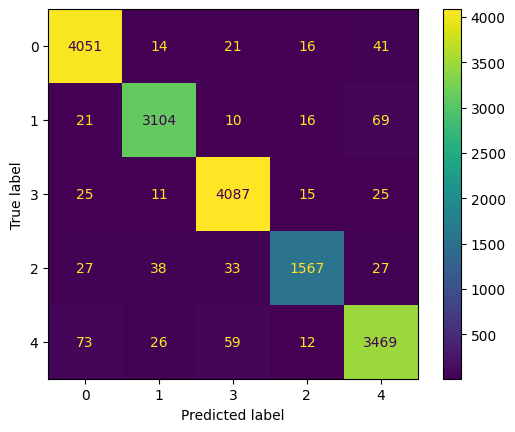

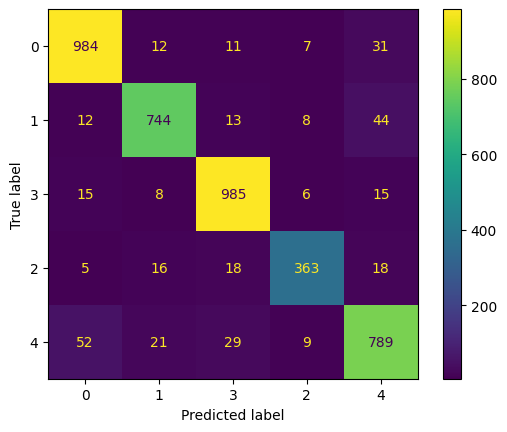

In [110]:
#running and evaluating the Logistic Regression model
params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 200, 300, 500, 1000],
    'class_weight': [None, 'balanced']
}
model=run_model(LogisticRegression(),params)
eval_model(train_y,model.predict(train_X),model.predict_proba(train_X),type='Training')
eval_model(test_y,model.predict(test_X),model.predict_proba(test_X),type='Test')